In [1]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)

In [3]:
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)


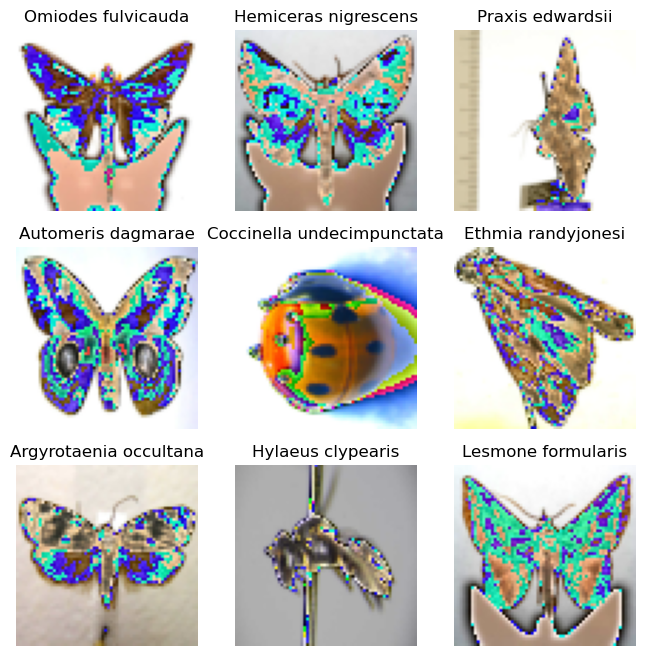

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

In [6]:
import random


nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.3)

train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

In [7]:
from torch.utils.data import Dataset, DataLoader

class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
whole_dataset = WholeDataset(image_dataset)
#whole_dataset[0][0].shape
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

32424


32424

In [ ]:
latent_size = 100 
embedding_size = 500
batch_size = 32

In [9]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


10777
6734
14913


In [10]:
n_classes = np.unique(whole_dataset.targets).shape[0]

In [11]:

class Discriminator(torch.nn.Module):

    def __init__(self,n_feature_maps):
        super(Discriminator, self).__init__()
        #input 3x256x256
        self.conv1 = nn.Sequential(nn.Conv2d(3,n_feature_maps,4,2,1,bias=False),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Dropout(0.5))
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature_maps,n_feature_maps*2,4,1,0,bias=False),
                                   nn.BatchNorm2d(n_feature_maps*2),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Dropout(0.5))
        self.conv3 = nn.Sequential(nn.Conv2d(n_feature_maps*2,n_feature_maps*4,4,2,1,bias=False),
                                   nn.BatchNorm2d(n_feature_maps*4),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Dropout(0.5))
        self.conv4 = nn.Sequential(nn.Conv2d(n_feature_maps*4,n_feature_maps*8,4,1,0,bias=False),
                                   nn.BatchNorm2d(n_feature_maps*8),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Dropout(0.5))
        self.conv5 = nn.Sequential(nn.Conv2d(n_feature_maps*8,n_feature_maps*16,4,2,1,bias=False),
                                   nn.BatchNorm2d(n_feature_maps*16),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Dropout(0.5))
        self.conv6 = nn.Sequential(nn.Conv2d(n_feature_maps*16,n_feature_maps*16,4,1,0,bias=False),
                                   nn.BatchNorm2d(n_feature_maps*16),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Dropout(0.5))
        
        self.main = nn.Sequential(self.conv1,
                                  self.conv2,
                                  self.conv3,        
                                  self.conv4,
                                  self.conv5,
                                  self.conv6)
        self.flatten = nn.Flatten() 
        self.linear_realfake = nn.Linear(4096,1)
        self.linear_class = nn.Linear(4096,1050)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax() 
    def forward(self, x):
        x = self.main(x)
        x = self.flatten(x)
        realfake = self.linear_realfake(x)
        realfake = self.sigmoid(realfake)
        classes = self.linear_class(x)
        classes = self.softmax(classes)
        return realfake,classes
        

class Generator(nn.Module):
    def __init__(self, n_feature_maps,noise_size):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(n_classes,embedding_size)
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( noise_size+embedding_size, n_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_feature_maps * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(n_feature_maps * 8, n_feature_maps* 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( n_feature_maps * 4, n_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( n_feature_maps * 2, n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( n_feature_maps, 3, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(n_feature_maps),
            #nn.ReLU(True),
            #nn.ConvTranspose2d( n_feature_maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, latent_noise,class_label):
        class_embedding = self.embed(class_label)
        class_embedding = class_embedding.unsqueeze(-1).unsqueeze(-1)
        concatenated_input = torch.cat((latent_noise,class_embedding),dim=1)
        return self.main(concatenated_input)
        
discriminator = Discriminator(64)
discriminator.cuda()


generator = Generator(64,noise_size=100)
generator.cuda()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#discriminator_scheduler = torch.optim.lr_scheduler.OneCycleLR(discriminator_optimizer,max_lr=0.005,epochs= 25, steps_per_epoch= 10) 

generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#generator_scheduler = torch.optim.lr_scheduler.OneCycleLR(generator_optimizer,max_lr=0.005,epochs= 25, steps_per_epoch= 10) 

In [12]:
n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


32233243
8197704


In [13]:
import os
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    random_classes = torch.tensor(np.random.randint(0, n_classes, fixed_latent.shape[0]),device=device)
    fake_images = generator(latent_tensors,random_classes)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [14]:
from tqdm.notebook import tqdm

fixed_latent = torch.randn(200, latent_size, 1, 1,device=device)
def train_discriminator(real_images,real_classes , discriminator_optimizer,discriminator,batch_size,latent_size,device):
    # Clear discriminator gradients
    discriminator_optimizer.zero_grad()

    # Pass real images through discriminator
    real_preds,real_predicted_classes = discriminator(real_images)
    real_preds_targets = torch.ones(real_images.size(0), 1, device=device)
    
    #AGGIUNGERE LA LOSS PER LE CLASSI, DOBBIAMO AGGIUNGERE LE TARGET CLASS COME 
    #PARAMETRO DI QUESTA FUNZIONE
    '''loss_pred_real + loss_class_real +
    loss_pred_fake + loss_class_fake'''
  
    real_loss = nn.functional.binary_cross_entropy(real_preds, real_preds_targets) + nn.functional.nll_loss(real_predicted_classes,real_classes)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    random_classes = torch.tensor(np.random.randint(0, n_classes, batch_size),device=device)
    fake_images = generator(latent,random_classes)

    # Pass fake images through discriminator
    fake_preds_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds,fake_predicted_classes = discriminator(fake_images)
    fake_loss = nn.functional.binary_cross_entropy(fake_preds, fake_preds_targets) + nn.functional.nll_loss(fake_predicted_classes,random_classes)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    discriminator_optimizer.step()
    return loss.item(), real_score, fake_score
    
def train_generator(generator_optimizer,generator,batch_size,latent_size,device):
    # Clear generator gradients
    generator_optimizer.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1,device=device)
    random_classes = torch.tensor(np.random.randint(0, n_classes, batch_size),device=device)

    
    fake_images = generator(latent,random_classes)
    # Try to fool the discriminator
    preds,predicted_classes = discriminator(fake_images)
    preds_targets = torch.ones(batch_size, 1, device=device)
    
    loss_preds = nn.functional.binary_cross_entropy(preds, preds_targets)
    
    # target must not be one-hot encoded while predicted classes are batch_size x number_of_classes log probabilities
    loss_class = nn.functional.nll_loss(predicted_classes,random_classes)
    

    loss = loss_class + loss_preds
    # Update generator weights
    loss.backward()
    generator_optimizer.step()
    
    return loss.item()
def fit(epochs,discriminator_optimizer,generator_optimizer,discriminator,generator,start_idx=1,latent_size =100):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    for epoch in range(epochs):
        for real_images, real_classes in tqdm(dataloaders['train']):
            # Train discriminator
            real_images = real_images.to(device)
            real_classes = real_classes.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, real_classes,discriminator_optimizer,discriminator,batch_size,latent_size,device)
            # Train generator
            loss_g = train_generator(generator_optimizer,generator,batch_size,latent_size,device)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [15]:
#train_model(tinymodel,torch.nn.CrossEntropyLoss(),optimizer,scheduler)

In [ ]:
losses_g, losses_d ,real_scores, fake_scores =fit(100,discriminator_optimizer,generator_optimizer,discriminator,generator,start_idx=1)

  0%|          | 0/337 [00:00<?, ?it/s]

/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], loss_g: 2.5426, loss_d: 0.5612, real_score: 0.8255, fake_score: 0.2680
Saving generated-images-0001.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 1.6221, loss_d: 0.8035, real_score: 0.6587, fake_score: 0.3312
Saving generated-images-0002.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 1.5012, loss_d: 0.4913, real_score: 0.8220, fake_score: 0.2177
Saving generated-images-0003.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 2.6162, loss_d: 1.1358, real_score: 0.8734, fake_score: 0.6040
Saving generated-images-0004.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.8406, loss_d: 0.7552, real_score: 0.8335, fake_score: 0.4083
Saving generated-images-0005.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 0.7717, loss_d: 0.7051, real_score: 0.6359, fake_score: 0.1865
Saving generated-images-0006.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.4896, loss_d: 1.1405, real_score: 0.3644, fake_score: 0.0559
Saving generated-images-0007.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 1.6484, loss_d: 0.7268, real_score: 0.7459, fake_score: 0.3709
Saving generated-images-0008.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 1.2709, loss_d: 0.8257, real_score: 0.5036, fake_score: 0.1497
Saving generated-images-0009.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 1.0899, loss_d: 0.7548, real_score: 0.8326, fake_score: 0.4278
Saving generated-images-0010.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.4031, loss_d: 0.9138, real_score: 0.6523, fake_score: 0.3436
Saving generated-images-0011.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.6296, loss_d: 1.6803, real_score: 0.3747, fake_score: 0.3403
Saving generated-images-0012.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 1.8009, loss_d: 0.7271, real_score: 0.8208, fake_score: 0.5291
Saving generated-images-0013.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.1802, loss_d: 0.6830, real_score: 0.7411, fake_score: 0.4094
Saving generated-images-0014.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.9626, loss_d: 1.2815, real_score: 0.5215, fake_score: 0.4373
Saving generated-images-0015.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 1.3112, loss_d: 1.2893, real_score: 0.4936, fake_score: 0.4812
Saving generated-images-0016.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 1.4583, loss_d: 0.5378, real_score: 0.7070, fake_score: 0.3166
Saving generated-images-0017.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 0.7917, loss_d: 1.0182, real_score: 0.6112, fake_score: 0.4446
Saving generated-images-0018.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 1.0605, loss_d: 0.9663, real_score: 0.5760, fake_score: 0.4268
Saving generated-images-0019.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.9893, loss_d: 0.9565, real_score: 0.5683, fake_score: 0.4072
Saving generated-images-0020.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.4859, loss_d: 1.1656, real_score: 0.4713, fake_score: 0.3666
Saving generated-images-0021.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.0804, loss_d: 1.1556, real_score: 0.4353, fake_score: 0.3340
Saving generated-images-0022.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.7007, loss_d: 1.0453, real_score: 0.5752, fake_score: 0.5081
Saving generated-images-0023.png


  0%|          | 0/337 [00:00<?, ?it/s]

In [ ]:
torch.save({
            'epoch':100,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/2048generator_checkpoint100")
torch.save({
            'epoch': 100,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/2048discriminator_checkpoint100")

In [ ]:
torch.nn.functional.NLLL